In [1]:
#!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install torch-geometric

# link prediction


In [3]:
import torch
import optuna
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
import numpy as np
from modules.model import Net
from sklearn.metrics import f1_score
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
from datetime import datetime
import random
from torch_geometric.data import GraphSAINTNodeSampler
import pickle
from torch_geometric.data import Data
import collections
import pickle
import os
from sklearn.metrics import roc_auc_score
import itertools

In [4]:
def dataprocess(data):
        #splitting data to train and test
        train_edge_index = []
        test_edge_index = []
        val_edge_index = []
        d = datetime.now()
        indices_to_delete_for_val  = random.choices(list(range(len(data.edge_index[0]))), k = int(len(data.edge_index[0])*0.2))
        indices_to_delete_for_test  = random.choices( list(set(range(len(data.edge_index[0]))) - set(indices_to_delete_for_val)) , k = int(len(list(set(range(len(data.edge_index[0]))) - set(indices_to_delete_for_val))) *0.625))
      #  print(datetime.now()-d)
        d = datetime.now()
        for i,x in enumerate(list(zip(*data.edge_index.tolist()))):
            if i in indices_to_delete_for_test:
                test_edge_index.append(x)
            elif i in indices_to_delete_for_val: 
                val_edge_index.append(x)
            else: 
                train_edge_index.append(x)
        val_edge_index = torch.tensor(np.array(list(zip(*val_edge_index))))
        test_edge_index = torch.tensor(np.array(list(zip(*test_edge_index))))
        train_edge_index = torch.tensor(np.array(list(zip(*train_edge_index))), dtype = torch.long)
       # print(datetime.now()-d)
        d = datetime.now()
        s = set(itertools.combinations(range(len(data.x)), 2))
       # print(datetime.now()-d)
        d = datetime.now()
        s_of_edges = set()
        for pair in (data.edge_index.t().tolist()):
            s_of_edges.add(tuple(pair))
        s_of_non_edges = s - s_of_edges
        #append negative samples to test set
        non_edges=[]
      #  print(datetime.now()-d)
        d = datetime.now()
        for pair in list(s_of_non_edges):
            non_edges.append(list(pair))
      #  print(datetime.now()-d)
        d = datetime.now()   
        non_edges_test=torch.tensor(random.choices(non_edges, k = len(test_edge_index[0]))).t()
        non_edges_val=torch.tensor(random.choices(non_edges, k = len(val_edge_index[0]))).t()
        y_true_val = [1]*len(val_edge_index[0])
        y_true_test = [1]*len(test_edge_index[0])
        test_edge_index=torch.cat((test_edge_index,non_edges_test),1)
        val_edge_index=torch.cat((val_edge_index,non_edges_val),1)
        y_true_test += [0]*len(non_edges_test[0])
        y_true_val += [0]*len(non_edges_val[0])
        data.edge_index = train_edge_index
        return data,non_edges_test,non_edges_val,test_edge_index,val_edge_index,y_true_test,y_true_val
    


In [5]:
def dataprocess_train(data):
        #splitting data to train and test
        train_edge_index =data.edge_index
        s = set(itertools.combinations(range(len(data.x)), 2))
       
        s_of_edges = set()
        for pair in (data.edge_index.t().tolist()):
            s_of_edges.add(tuple(pair))
        s_of_non_edges = s - s_of_edges
        #append negative samples to test set
        non_edges=[]
      #  print(datetime.now()-d)
        d = datetime.now()
        for pair in list(s_of_non_edges):
            non_edges.append(list(pair))
      #  print(datetime.now()-d)
        d = datetime.now()   
        non_edges_train=torch.tensor(random.choices(non_edges, k = len(train_edge_index[0]))).t()
        y_true_train = [1]*len(train_edge_index[0])+[0]*len(train_edge_index[0])
        return data,non_edges_train,y_true_train
    


In [6]:
flag = False
if flag:
    with open('datasets/CA-GrQc.txt','r') as f:
        data_Arxiv = f.readlines()

    new_list=list(map(lambda x: x.split('\t'),data_Arxiv[4:]))
    #print(new_list)
    dataedge = list(map(lambda x: [int(x[0]),int(x[1].split('\n')[0])],new_list))
    set2=set(collections.Counter((np.array(dataedge)).transpose()[1]).keys()) | set(collections.Counter((np.array(dataedge)).transpose()[0]).keys())
    map_ar={}
    for j,i in enumerate(set2):
        map_ar[i] = j

    dataedge_ar_new = list(map(lambda x: [map_ar[x[0]],map_ar[x[1]]], dataedge))

    data_edge_index_Arxiv = torch.tensor(dataedge_ar_new).t()
    x  = torch.nn.init.xavier_uniform_(torch.empty(len(set2), 128 ))
    data = Data(edge_index=data_edge_index_Arxiv,x = x)
    data,non_edges_test,non_edges_val,test_edge_index,val_edge_index,y_true_test,y_true_val = dataprocess(data)
    with open('data_arxiv.pickle','wb') as f:
        pickle.dump(data,f)
    with open('non_edges_test_arxiv.pickle','wb') as f:
        pickle.dump(non_edges_test,f)
    with open('non_edges_val_arxiv.pickle','wb') as f:
        pickle.dump(non_edges_val,f)
    with open('test_edge_index_arxiv.pickle','wb') as f:
        pickle.dump(test_edge_index,f)
    with open('y_true_test_arxiv.pickle','wb') as f:
        pickle.dump(y_true_test,f)
    with open('y_true_val_arxiv.pickle','wb') as f:
        pickle.dump(y_true_val,f)
    with open('val_edge_index_arxiv.pickle','wb') as f:
        pickle.dump(val_edge_index,f)

else:
    with open('data_arxiv.pickle','rb') as f:
        data=pickle.load(f)
    with open('non_edges_test_arxiv.pickle','rb') as f:
        non_edges_test=pickle.load(f)
    with open('non_edges_val_arxiv.pickle','rb') as f:
        non_edges_val=pickle.load(f)
    with open('test_edge_index_arxiv.pickle','rb') as f:
        test_edge_index=pickle.load(f)
    with open('y_true_test_arxiv.pickle','rb') as f:
        y_true_test=pickle.load(f)
    with open('y_true_val_arxiv.pickle','rb') as f:
        y_true_val=pickle.load(f)
    with open('val_edge_index_arxiv.pickle','rb') as f:
        val_edge_index=pickle.load(f)
    with open('non_edges_train.pickle','rb') as f:
        non_edges_train=pickle.load(f)
    with open('y_true_train.pickle','rb') as f:
        y_true_train=pickle.load(f)


In [7]:
# _,non_edges_train,y_true_train=dataprocess_train(data)
#with open('non_edges_train.pickle','wb') as f:
#       pickle.dump(non_edges_train,f)
#with open('y_true_train.pickle','wb') as f:
#       pickle.dump(y_true_train,f)


In [8]:
def CrossEntropy(y_pred, y_true):
    loss=0
    for i,l in enumerate(y_true):
        if l == 1:
            loss+= -log(y_pred[i])
        else:
            loss+= -log(1 - y_pred[i])
    return loss
from torch_geometric.datasets import Flickr
class Main():
    def __init__(self,conv, dataset, non_edges_test,non_edges_val,test_edge_index,val_edge_index,y_true_test,y_true_val,non_edges_train,y_true_train, device, loss_function,mode,**kwargs):
        data = dataset
        self.Conv = conv
        self.device = device
        self.data=data.to(device)
        self.non_edges_test =non_edges_test
        self.non_edges_val =non_edges_val
        self.y_true_val = y_true_val
        self.y_true_test =y_true_test 
        self.test_edge_index =test_edge_index
        self.val_edge_index =val_edge_index
        self.loss = loss_function
        self.mode = mode
        self.mask = torch.tensor([True]*len(data.x))
        self.flag = self.loss["flag_tosave"]
        self.non_edges_train =non_edges_train
        self.y_true_train = y_true_train
    
        super(Main, self).__init__()
    
    def sampling(self,Sampler,epoch,nodes,loss):
        if (epoch == 0): 
            if self.flag:  
                if "alpha" in self.loss: 
                    name_of_file = "LP_samples_"+loss["Name"]+"_alpha_"+str(self.loss["alpha"])+".pickle"
                elif "alpha" in self.loss: 
                    name_of_file = "LP_samples_"+loss["Name"]+"_betta_"+str(self.loss["betta"])+".pickle"
                else:
                    name_of_file = "LP_samples_"+loss["Name"]+".pickle"
                
                if os.path.exists(name_of_file):
                    with open(name_of_file,'rb') as f:
                        self.samples = pickle.load(f)
                else:
                    self.samples = Sampler.sample(nodes) 
                    with open(name_of_file,'wb') as f:
                        pickle.dump(self.samples,f)
            else:
                
                self.samples = Sampler.sample(nodes)
        return self.samples
    def train(self, model,data,optimizer,Sampler,train_loader,dropout,epoch,loss):
        model.train()   
        total_loss = 0
        optimizer.zero_grad()
        if model.mode == 'unsupervised':
            print('unsup')
            if model.conv=='GCN':
                out = model.inference(data.to(device),dp=dropout)
                samples = self.sampling(Sampler,epoch, (list(range(len(data.x)))),loss)
                loss = model.loss(out, self.samples)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(device)].to(device), adjs)
                    samples = self.sampling(Sampler,epoch,n_id[:batch_size],loss)   
                   
                #print(out.shape, self.samples.shape)
                    loss = model.loss(out, self.samples)#pos_batch.to(device), neg_batch.to(device))
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
        else: 
            if model.conv=='GCN':
                out = model.inference(data.to(device),dp=dropout)
                out_d = torch.sigmoid(sum((out[data.edge_index[0]]*out[data.edge_index[1]]).t()))
                out_n = torch.sigmoid(sum((out[non_edges_train[0]]*out[non_edges_train[1]]).t()))
                y_pred = torch.cat((out_d,out_n))  
                
                y=self.y_true_train
                #y_pred = torch.tensor(y_pred).to('cuda')
                #print(out[0],out[1])
                #print( torch.dot(out[0],out[1]))
                y_true = torch.tensor(y).to('cuda')
                ones_true = torch.ones(len(y_true)).to('cuda')
                ones_pred=torch.ones(len(y_pred)).to('cuda')
                loss_vec = (y_true*torch.log(y_pred)+(ones_true-y_true)*torch.log(ones_pred-y_pred))#.requires_grad_(True)
                if sum(torch.isnan(loss_vec))>0:
                    while sum(torch.isnan(loss_vec))>0:
                        if y_true[(torch.isnan(loss_vec)).nonzero()[0]]==1:
                            loss_vec[(torch.isnan(loss_vec)).nonzero()[0]]=0
                        else:
                            print('BIG PROBLEM')
                loss = -sum(loss_vec)
                total_loss+=loss
            else:
                for batch_size, n_id, adjs in train_loader:
                    if len(train_loader.sizes) == 1:
                        adjs = [adjs]
                    adjs = [adj.to(device) for adj in adjs]
                    out = model.forward(data.x[n_id.to(device)].to(device), adjs)
                    out_d = torch.sigmoid(sum((out[data.edge_index[0]]*out[data.edge_index[1]]).t()))
                    out_n = torch.sigmoid(sum((out[non_edges_train[0]]*out[non_edges_train[1]]).t()))
                    y_pred = torch.cat((out_d,out_n)) 
                    y=self.y_true_train
                    y_true = torch.tensor(y).to('cuda')
                    ones_true = torch.ones(len(y_true)).to('cuda')
                    ones_pred=torch.ones(len(y_pred)).to('cuda')
                    loss_vec = -sum(y_true*torch.log(y_pred)+(ones_true-y_true)*torch.log(ones_pred-y_pred)).requires_grad_()
                    total_loss+=loss
            total_loss.backward()
            optimizer.step()      
        return total_loss# /len(train_loader)
                

    @torch.no_grad()
    def val_lp(self,model,data,classifier): 
        model.eval()
        out = model.inference(data.to(device))
        out = out.cpu()
        
        y_true = np.array(self.y_true_val)
        if True:
            y_pred = []
            for x in list(zip(*self.val_edge_index)):
                y_pred.append(float(torch.sigmoid(torch.dot(out[x[0]],out[x[1]]))))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
            return roc_auc_score(y_true,np.array(y_pred)) 
            #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]
    def test_lp(self,model,data,classifier): 
        model.eval()
        out = model.inference(data.to(device))
        out = out.cpu()
        y_true = np.array(self.y_true_test)
        if True:
            y_pred = []
            for x in list(zip(*self.test_edge_index)):
                y_pred.append(float(torch.sigmoid(torch.dot(out[x[0]],out[x[1]]))))#print(torch.sigmoid(torch.dot(out[x[0]],out[x[1]])))
            return roc_auc_score(y_true,torch.tensor(y_pred).cpu().detach().numpy()) 
      
    def run(self,hidden_layer=64,out_layer=128,dropout=0.0,size=1,learning_rate=0.001):
        hidden_layer = hidden_layer
        out_layer = out_layer
        dropout = dropout
        size = size

        learning_rate = learning_rate
    
        classifier = "logistic regression"
        train_loader = NeighborSampler(self.data.edge_index, batch_size = int(len(self.data.x)), sizes=[-1]*size)
        Sampler=self.loss["Sampler"]
        LossSampler = Sampler(self.data,device=device,mask=self.mask,loss_info=self.loss)
        model = Net(dataset = self.data,mode=self.mode,conv=self.Conv,loss_function=self.loss,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = (size),dropout = dropout)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)
                #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        scheduler=lr_scheduler.StepLR(optimizer, step_size=25,gamma=0.1)
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+self.loss["Name"]

        print(name_of_plot)

        for epoch in range(100):
                    print('epoch',epoch)
                    loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,self.loss)
                    losses.append(loss)
                    d_test = datetime.now()
                    test_acc = self.test_lp(model,self.data,'logistic regression')
                    test_accs.append(test_acc)
                    log = 'Loss: {:.4f}, Epoch: {:03d}, Test: {:.4f}'
                    #scheduler.step()
                    print(log.format(loss, epoch, test_acc))
        print('Test acc on the last epoch ', test_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        plt.plot(test_accs)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
                    #return [precision_score(y_true[train_mask.cpu()], best_preds_train, average='macro'), precision_score(y_true[val_mask.cpu()], best_preds_val, average='macro'),precision_score(y_true[test_mask.cpu()], best_preds, average='macro')]

In [9]:
class MainOptuna(Main):
    def objective(self,trial):
        # Integer parameter
        hidden_layer = trial.suggest_categorical("hidden_layer", [32,64,128,256])
        out_layer = trial.suggest_categorical("out_layer", [32,64,128])
        dropout = trial.suggest_float("dropout", 0.0,0.5,step = 0.1)
        size = trial.suggest_categorical("size of network, number of convs", [1,2,3])
        Conv = self.Conv# trial.suggest_categorical("conv", ["SAGE","GCN","GAT"])

        # варьируем параметры
        loss_to_train={}
        for name in self.loss:
            
            if type(self.loss[name]) == list :
                if len(self.loss[name]) == 3:
                    var = trial.suggest_int(name,self.loss[name][0],self.loss[name][1],step=self.loss[name][2])
                    loss_to_train[name] = var
                elif len(self.loss[name]) == 2:
                    var_2 = trial.suggest_float(name,self.loss[name][0],self.loss[name][1])
                    loss_to_train[name] = var_2
                else:
                    var_3 = trial.suggest_categorical(name, self.loss[name])
                    loss_to_train[name] = var_3
            else:
                loss_to_train[name] = self.loss[name]
        Sampler =loss_to_train["Sampler"]
        model = Net(dataset = self.data,mode=self.mode,conv=Conv,loss_function=loss_to_train,device=device,hidden_layer=hidden_layer,out_layer =out_layer,num_layers = size,dropout = dropout)

        train_loader = NeighborSampler(self.data.edge_index, batch_size =int(len(self.data.x)), sizes=[-1]*size)
        
        #train_loader = GraphSAINTRandomWalkSampler(data, batch_size=2176, walk_length=2,num_steps=5, sample_coverage=100,save_dir=dataset.processed_dir,num_workers=4)

        LossSampler = Sampler(self.data,device=self.device,mask=self.mask,loss_info=loss_to_train)

        model.to(device)

        learning_rate= trial.suggest_float("lr",5e-4,1e-2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay = 1e-5)  

        classifier = "logistic regression" #trial.suggest_categorical("classifier", ["logistic regression", "catboost"])

        if classifier == "catboost":
            n_estimators = trial.suggest_int("n of estimators", 10,40,5)
            learning_rate_catboost = trial.suggest_float("lr_catboost",5e-4,1e-2)
            max_depth = trial.suggest_int("max_depth",1,10,2)
        else:
            n_estimators = -1
            learning_rate_catboost =-1
            max_depth = -1
        #training of the model
        for epoch in range(50):
            
            loss = self.train(model,self.data,optimizer,LossSampler,train_loader,dropout,epoch,loss_to_train)


        val_acc = self.val_lp(model,self.data,classifier)
        print(val_acc)

        trial.report(val_acc,epoch)

        return val_acc

    
    def run(self,number_of_trials):

        study = optuna.create_study(direction="maximize",study_name=self.loss["Name"]+" loss,"+str(self.Conv)+" conv")
        study.optimize(self.objective,n_trials = number_of_trials)

        print('Best trial:')
        trial = study.best_trial
        print(" Value: ", trial.value)
        print(" Params: ")
        for key, value in trial.params.items():
            print(" {}: {}".format(key,value))
    

In [10]:
from modules.sampling import Sampler, SamplerContextMatrix, SamplerRandomWalk,SamplerFactorization,SamplerAPP
#хорошо
DeepWalk = {"Name": "DeepWalk","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p":1,"q":1,"loss var": "Random Walks","flag_tosave":False,"Sampler" : SamplerRandomWalk } #Проблемы с памятью после того, как увеличила количество тренировочных данных
Node2Vec = {"Name": "Node2Vec","walk_length":[5,20,5],"walks_per_node":[5,20,5],"num_negative_samples":[1,21,5],"context_size" : [5,20,5],"p": [0.25, 0.50, 1, 2, 4] ,"q":[0.25, 0.50, 1, 2, 4], "loss var": "Random Walks","flag_tosave":False,"Sampler": SamplerRandomWalk}#то же самое 
LINE = {"Name": "LINE","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix} 

#плохо
HOPE_RPR = {"Name": "HOPE_RPR","C":"RPR","loss var": "Factorization","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить
HOPE_Katz = {"Name": "HOPE_Katz","C":"Katz","loss var": "Factorization","flag_tosave":True,"betta": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} #проверить
HOPE_AA = {"Name": "HOPE_AdamicAdar","C":"AA","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} 
LapEigen = {"Name": "LaplacianEigenMaps", "C":"Adj","loss var": "Laplacian EigenMaps","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]}
VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerContextMatrix}

VERSE_SR =  {"Name": "VERSE_SimRank","C": "SR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"Sampler":SamplerContextMatrix} 

Struc2Vec ={} #Implement
GraphFactorization = {"Name": "Graph_Factorization","C":"Adj","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} 
HOPE_CN = {"Name": "HOPE_CommonNeighbors","C":"CN","loss var": "Factorization","flag_tosave":True,"Sampler" :SamplerFactorization,"lmbda": [0.0,1.0]} 
APP ={"Name": "APP","C": "PPR","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":True,"alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],"Sampler" :SamplerAPP}
VERSE_Adj =  {"Name": "VERSE_Adj","C": "Adj","num_negative_samples":[1,21,5],"loss var": "Context Matrix","flag_tosave":False,"Sampler" :SamplerContextMatrix} 


conv: SAGE, mode: unsupervised, loss from VERSE_PPR
epoch 0
unsup
Loss: 0.9349, Epoch: 000, Test: 0.6277
epoch 1
unsup
Loss: 0.7959, Epoch: 001, Test: 0.6170
epoch 2
unsup
Loss: 0.7182, Epoch: 002, Test: 0.6159
epoch 3
unsup
Loss: 0.7057, Epoch: 003, Test: 0.5629
epoch 4
unsup
Loss: 0.7044, Epoch: 004, Test: 0.5367
epoch 5
unsup
Loss: 0.7037, Epoch: 005, Test: 0.5551
epoch 6
unsup
Loss: 0.7001, Epoch: 006, Test: 0.6184
epoch 7
unsup
Loss: 0.6978, Epoch: 007, Test: 0.6191
epoch 8
unsup
Loss: 0.6958, Epoch: 008, Test: 0.5748
epoch 9
unsup
Loss: 0.6952, Epoch: 009, Test: 0.5748
epoch 10
unsup
Loss: 0.6945, Epoch: 010, Test: 0.6238
epoch 11
unsup
Loss: 0.6941, Epoch: 011, Test: 0.6177
epoch 12
unsup
Loss: 0.6937, Epoch: 012, Test: 0.5928
epoch 13
unsup
Loss: 0.6938, Epoch: 013, Test: 0.6084
epoch 14
unsup
Loss: 0.6936, Epoch: 014, Test: 0.6322
epoch 15
unsup
Loss: 0.6936, Epoch: 015, Test: 0.6396
epoch 16
unsup
Loss: 0.6935, Epoch: 016, Test: 0.6361
epoch 17
unsup
Loss: 0.6935, Epoch: 017,

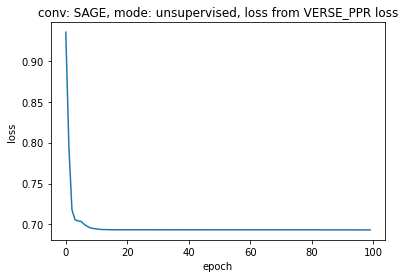

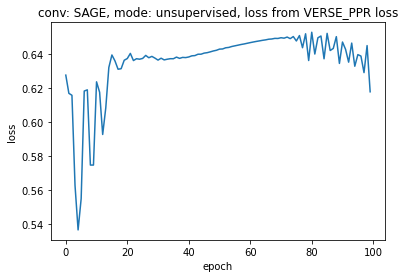

In [11]:
device=torch.device('cpu')
num_negative_samples= 16
alpha= 0.7
VERSE_PPR =  {"Name": "VERSE_PPR","C": "PPR","num_negative_samples":num_negative_samples,"loss var": "Context Matrix","flag_tosave":False,"alpha":alpha,"Sampler" :SamplerContextMatrix}

loss=VERSE_PPR
MO = Main('SAGE', data, non_edges_test,non_edges_val,test_edge_index,val_edge_index,y_true_test,y_true_val,non_edges_train,y_true_train, device, loss, mode = 'unsupervised')
MO.run(hidden_layer=128,out_layer=128,dropout=0.0,size=3,learning_rate=0.00870953377523571)